# Spotify

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col,isnan, when, count
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pandas.plotting import scatter_matrix
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
import math
import pandas as pd
import numpy
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [3]:
sdf = spark.read.format("csv").option("header", "true").option(
    "inferSchema", "true").load("./data/Spotify-2000.csv")
sdf.show()

+-----+--------------------+-----------------+--------------------+----+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Index|               Title|           Artist|           Top Genre|Year|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+-----+--------------------+-----------------+--------------------+----+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|    1|             Sunrise|      Norah Jones|     adult standards|2004|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|    2|         Black Night|      Deep Purple|          album rock|2000|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|       

## Columns flush

In [4]:
sdf = sdf.drop("Title").drop("Year").drop("Year").drop("Index").drop("Artist").drop("Top Genre")
sdf = sdf.withColumn('Length (Duration)',col('Length (Duration)').cast(IntegerType()))

In [5]:
sdf.cache()

DataFrame[Beats Per Minute (BPM): int, Energy: int, Danceability: int, Loudness (dB): int, Liveness: int, Valence: int, Length (Duration): int, Acousticness: int, Speechiness: int, Popularity: int]

In [6]:
sdf.is_cached

True

In [7]:
sdf.printSchema()

root
 |-- Beats Per Minute (BPM): integer (nullable = true)
 |-- Energy: integer (nullable = true)
 |-- Danceability: integer (nullable = true)
 |-- Loudness (dB): integer (nullable = true)
 |-- Liveness: integer (nullable = true)
 |-- Valence: integer (nullable = true)
 |-- Length (Duration): integer (nullable = true)
 |-- Acousticness: integer (nullable = true)
 |-- Speechiness: integer (nullable = true)
 |-- Popularity: integer (nullable = true)



## Data exploration

In [8]:
sdf = sdf.na.drop()

In [9]:
sdf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in sdf.columns]).show()

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                     0|     0|           0|            0|       0|      0|                0|           0|          0|         0|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+



#### Scatter Matrix

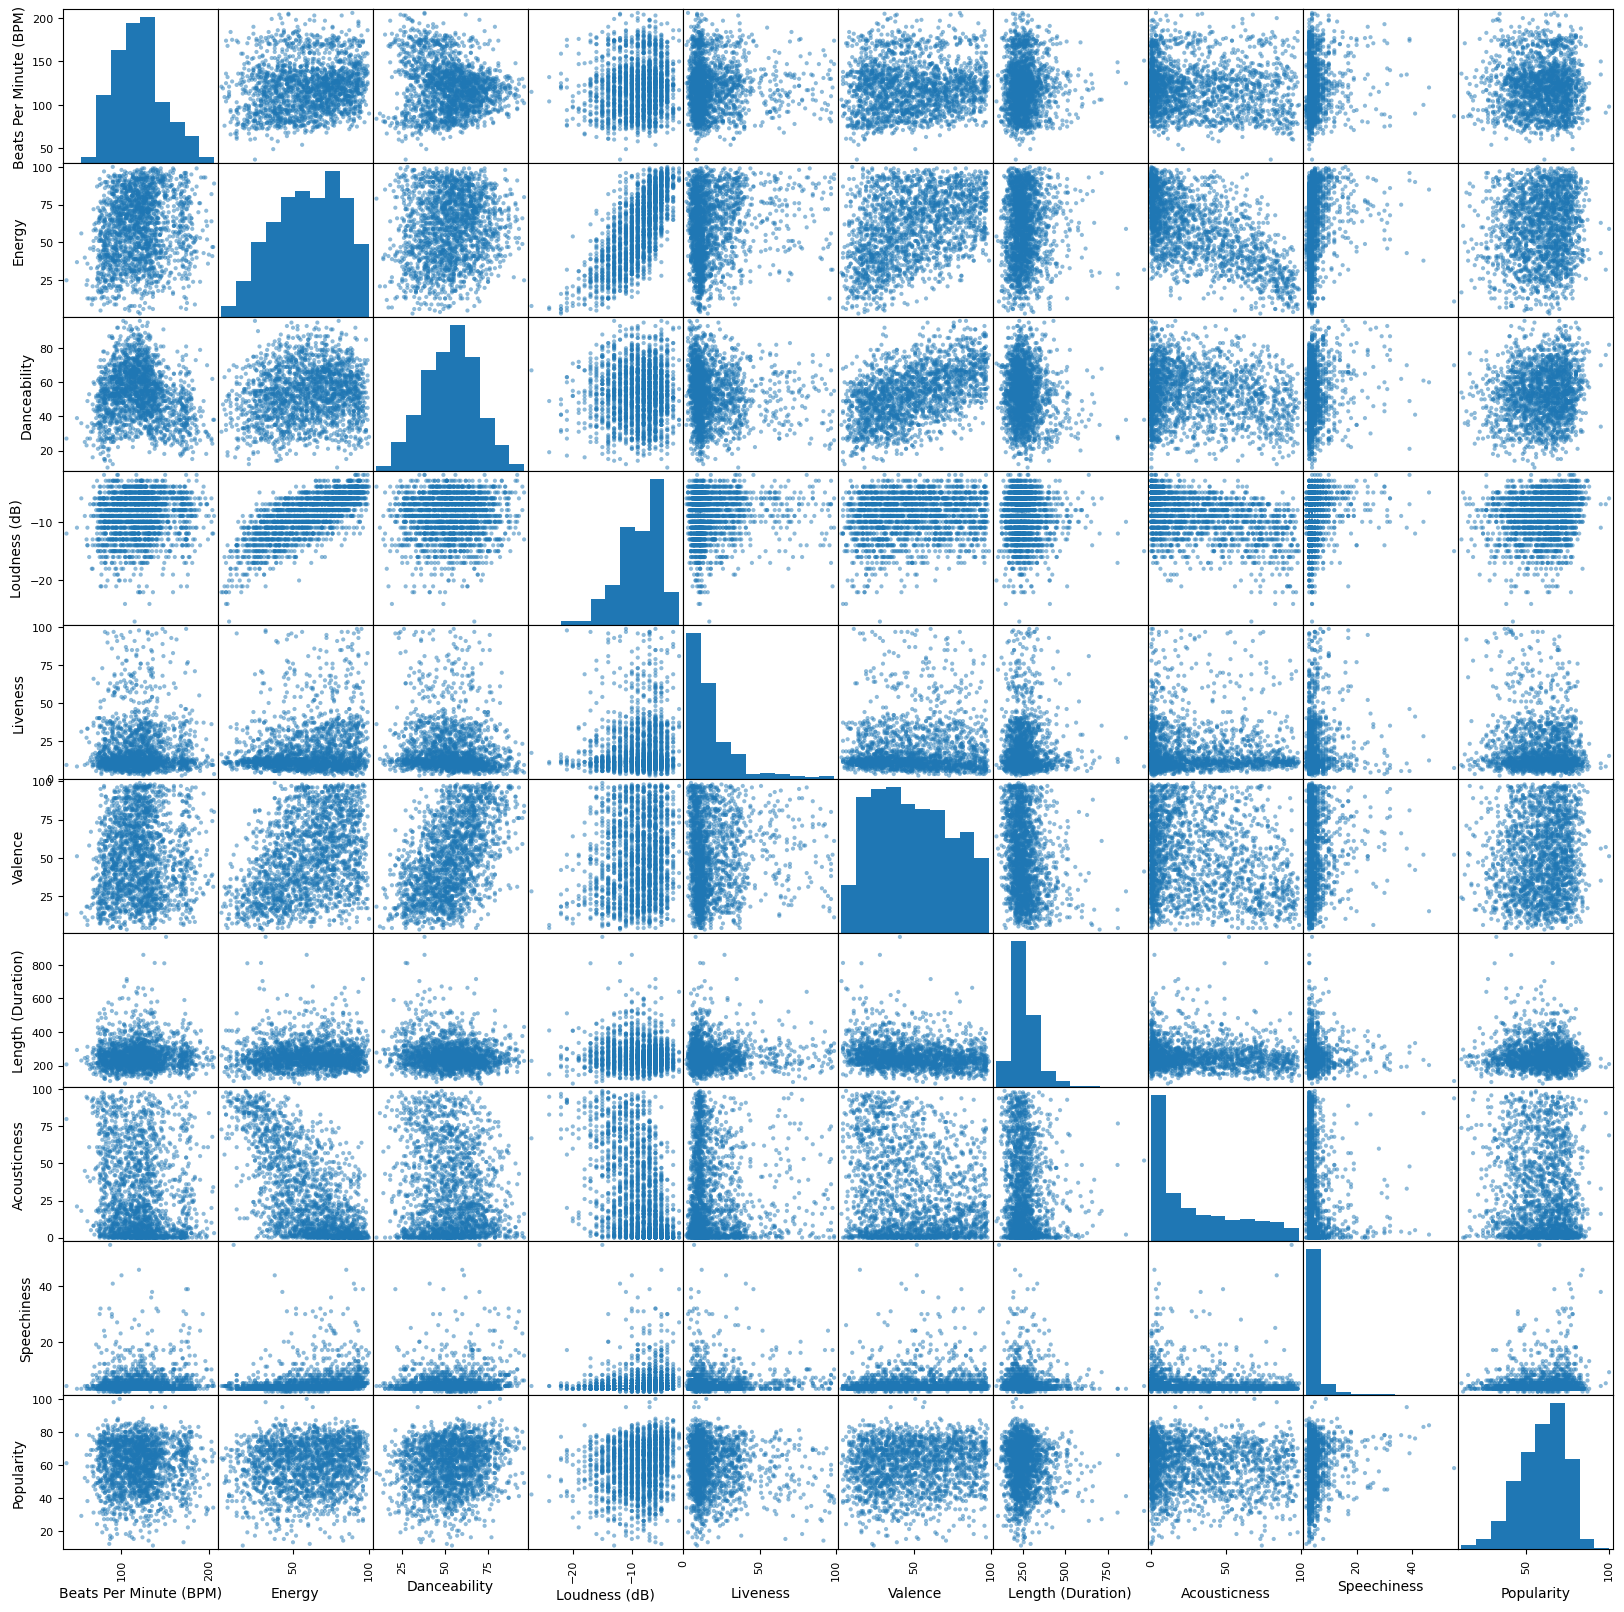

In [10]:
pandasSdf = sdf.toPandas()
scatterMatrix = scatter_matrix(pandasSdf,figsize=(20,20))

# Notre target est la colonne "Popularity"
# Nous avons choisi de l'utiliser en temps qu'axe Y pour étudier l'impact des autres colonnes sur la "Popularity"


## Describe

In [11]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_num = sdf.select([col[0] for col in sdf.dtypes if col[1] != 'string'])
col_num.show()

feature_numeric = ['Beats Per Minute (BPM)', 'Energy', 'Danceability',  'Loudness (dB)', 'Liveness', 'Valence', 'Length (Duration)', 'Acousticness', 'Speechiness']

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|                   168|    69|          66|           -9|       7|     52|              341|           2|         17|        69|
|                   173|    96|          43|           -4|       3|     37|              269|           0|          4|        76|
|                   106|    82|          58|           -5|      10|     87|              2

In [12]:
sdf.describe().toPandas()  # # par défaut ttes les col 
sdf.dtypes
col_cat = sdf.select([col[0] for col in sdf.dtypes if col[1] == 'string'])
col_cat.show()

++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows



In [13]:
feature_cat = []
feature_cat_indexed = [col+'_indexed' for col in feature_cat]

# Define target : Popularity

In [14]:
labelCol = 'Popularity'

In [15]:
feature_cat_encoded = [col +'_encoded' for col in feature_cat_indexed]

In [16]:
feature_cat_encoded

[]

## StringIndexer

In [17]:
#indexer_feature = StringIndexer(inputCols=feature_cat, handleInvalid='skip', outputCols=feature_cat_indexed)
indexer_label = StringIndexer(inputCol=labelCol, handleInvalid='skip', outputCol=labelCol+'_indexed')
#sdf = indexer_feature.fit(sdf).transform(sdf)

## OneHotEncoder

In [18]:
sdf.show()

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                   157|    30|          53|          -14|      11|     68|              201|          94|          3|        71|
|                   135|    79|          50|          -11|      17|     81|              207|          17|          7|        39|
|                   168|    69|          66|           -9|       7|     52|              341|           2|         17|        69|
|                   173|    96|          43|           -4|       3|     37|              269|           0|          4|        76|
|                   106|    82|          58|           -5|      10|     87|              2

In [19]:
encoders = OneHotEncoder(dropLast=False, inputCols=feature_cat_indexed, outputCols=feature_cat_encoded)  # handleInvalid='skip',  
#sdf = encoders.fit(sdf).transform(sdf)
#sdf.select(feature_cat_indexed+feature_cat_encoded).show(n=2, truncate=False, vertical=True)

## VectorAssembler

In [20]:
# Vectorizing encoded values
# assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="rawFeatures")

assembler = VectorAssembler(inputCols=feature_cat_encoded+feature_numeric, outputCol='features')

#assembler.transform(sdf).select(feature_cat+feature_numeric+feature_cat_encoded+['features']).show(n=2, truncate=False, vertical=True)

## Pipeline LinearRegression

In [21]:
lr = LinearRegression(labelCol='Popularity_indexed', featuresCol='features')

train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

train.cache()
test.cache()
train.show()

lr_model = Pipeline(stages= [indexer_label]+[encoders]+[assembler] + [lr]).fit(train)
pred_lr = lr_model.transform(test)
pred_lr.select('prediction', 'Popularity_indexed', 'features').show()
pred_lr.show(n=1, vertical=True, truncate=False)

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+
|                    37|    25|          27|          -12|       9|     13|              207|          80|          4|        61|
|                    49|    37|          39|          -11|       8|     51|              293|          21|          3|        78|
|                    54|    56|          36|           -6|      31|     14|              230|          18|          3|        29|
|                    58|    40|          25|           -9|       9|     11|              245|          45|          4|        52|
|                    60|    22|          23|          -13|      27|     18|              2

In [22]:
squared = lr_model.stages[-1].summary.meanSquaredError

math.sqrt(squared)

15.633055699203593

## RandomForestRegressor

In [23]:
train, test = sdf.randomSplit([0.7, 0.3], seed = 11)

rf= RandomForestRegressor(labelCol='Popularity_indexed', featuresCol='features')

In [24]:
model = Pipeline(stages= [indexer_label]+[encoders]+[assembler] + [rf]).fit(train)


In [25]:
pred_rf = model.transform(test)
pred_rf.select('prediction', 'Popularity_indexed', 'features').show()
pred_rf.show(n=1, vertical=True, truncate=False)

+------------------+------------------+--------------------+
|        prediction|Popularity_indexed|            features|
+------------------+------------------+--------------------+
| 22.18701304284613|              42.0|[61.0,13.0,27.0,-...|
| 22.70719277583258|              11.0|[61.0,25.0,49.0,-...|
|19.286842586522887|              11.0|[66.0,9.0,36.0,-1...|
|25.311407049336854|              24.0|[67.0,12.0,16.0,-...|
|21.207398308242592|               0.0|[67.0,13.0,47.0,-...|
|22.535599091192747|              21.0|[67.0,21.0,31.0,-...|
| 21.06310485119084|              35.0|[68.0,47.0,35.0,-...|
| 22.71176265000501|              16.0|[68.0,51.0,33.0,-...|
|21.642747384988972|              36.0|[70.0,13.0,35.0,-...|
| 18.63647688707719|              58.0|[72.0,26.0,35.0,-...|
| 21.88010727032688|               3.0|[72.0,87.0,43.0,-...|
|22.242912210534417|               8.0|[73.0,26.0,52.0,-...|
|26.007652567798306|               6.0|[73.0,30.0,36.0,-...|
|21.324351100827425|    

In [26]:
model.stages[-1].trees

[DecisionTreeRegressionModel: uid=dtr_5705b0e8eb6c, depth=5, numNodes=47, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_51f450e5af8c, depth=5, numNodes=53, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_61e698f597bd, depth=5, numNodes=37, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_65dda6a55f53, depth=5, numNodes=49, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_b0624b6f0018, depth=5, numNodes=55, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_c3845f4fc390, depth=5, numNodes=63, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_491090248188, depth=5, numNodes=63, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_b7c7b7265d85, depth=5, numNodes=59, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_3a967551734c, depth=5, numNodes=63, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_a7db115c0f63, depth=5, numNodes=51, numFeatures=9,
 DecisionTreeRegressionModel: uid=dtr_9f9b8f2eac84, depth=5, numNodes=63, numFeatures=9,
 DecisionTreeRegressi

In [27]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Popularity_indexed", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(pred_rf)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[-1]
print(rfModel)  # summary only

Root Mean Squared Error (RMSE) on test data = 15.7082
RandomForestRegressionModel: uid=RandomForestRegressor_8031fa3d85cb, numTrees=20, numFeatures=9


In [28]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

## Class columns by score

In [29]:
ExtractFeatureImp(model.stages[-1].featureImportances, pred_rf, "features").head(10)

,idx,name,score
5,5,Valence,0.153128
0,0,Beats Per Minute (BPM),0.141970
6,6,Length (Duration),0.135790
1,1,Energy,0.110912
3,3,Loudness (dB),0.101273
4,4,Liveness,0.096092
7,7,Acousticness,0.092323
2,2,Danceability,0.087603
8,8,Speechiness,0.080908


## Scatter plots for regression Line

<AxesSubplot: xlabel='Beats Per Minute (BPM)', ylabel='prediction'>

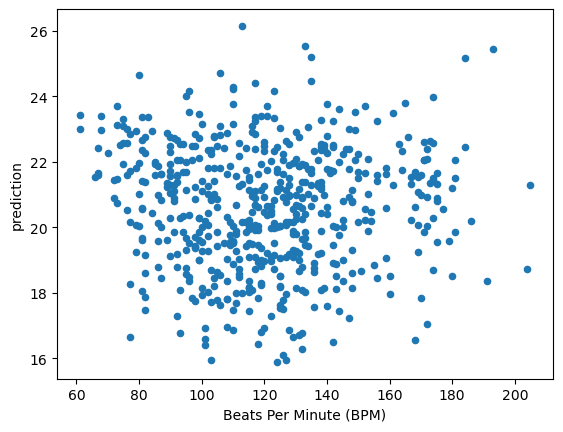

In [30]:
df = pred_lr.toPandas()


df.plot.scatter(x='Beats Per Minute (BPM)', y='prediction')

<AxesSubplot: xlabel='Beats Per Minute (BPM)', ylabel='Popularity'>

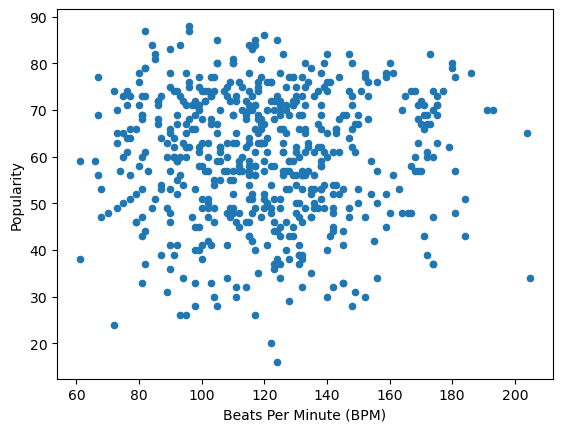

In [31]:
df.plot.scatter(x='Beats Per Minute (BPM)', y='Popularity')

### Tracing the Regression Line

In [32]:
list(lr_model.stages[-1].coefficients)

[0.0017673954134813789,
 -0.07899528479899781,
 -0.013737454216679284,
 0.26796398753218104,
 0.04749045042467818,
 -0.042252485069363306,
 0.0008896180899361826,
 -0.026425587182563322,
 0.07105262481610196]

In [33]:
60 * -0.079

-4.74

In [34]:
0.0018 * 60

0.108

In [35]:
pred_lr.columns

['Beats Per Minute (BPM)',
 'Energy',
 'Danceability',
 'Loudness (dB)',
 'Liveness',
 'Valence',
 'Length (Duration)',
 'Acousticness',
 'Speechiness',
 'Popularity',
 'Popularity_indexed',
 'features',
 'prediction']

In [36]:
tab1 = list(pred_lr.select(feature_numeric).collect()[0])

In [37]:
coeffs = list(lr_model.stages[-1].coefficients)

In [38]:
tab1

[61, 13, 27, -14, 33, 18, 232, 94, 4]

In [39]:
somme = 0
for i in range(len(coeffs)):
    somme += coeffs[i] * tab1[i]

In [40]:
somme

-6.228297837730993

In [41]:
pred_lr.show(1)

+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+------------------+--------------------+-----------------+
|Beats Per Minute (BPM)|Energy|Danceability|Loudness (dB)|Liveness|Valence|Length (Duration)|Acousticness|Speechiness|Popularity|Popularity_indexed|            features|       prediction|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+------------------+--------------------+-----------------+
|                    61|    13|          27|          -14|      33|     18|              232|          94|          4|        38|              42.0|[61.0,13.0,27.0,-...|23.42447743509704|
+----------------------+------+------------+-------------+--------+-------+-----------------+------------+-----------+----------+------------------+--------------------+-----------------+
only showing top 1 row



In [42]:
23.42447743509704 + somme

17.196179597366047

#### D'après le nuage de points suivant, les valeurs ne sont pas linéaires et donc la prédiction n'est pas influencée par l'"Acousticness"

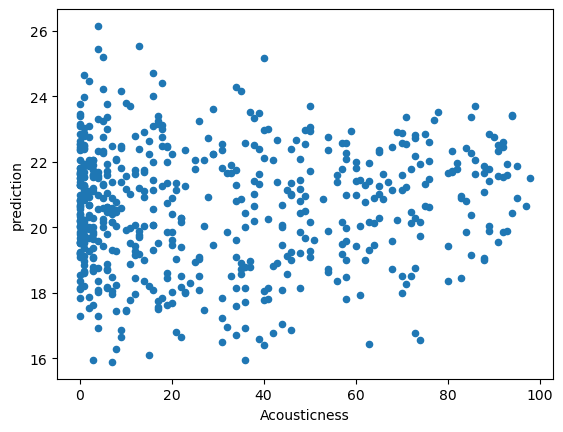

In [43]:
fig = df.plot.scatter(x="Acousticness", y="prediction")

### Source
#### https://towardsdatascience.com/predicting-popularity-on-spotify-when-data-needs-culture-more-than-culture-needs-data-2ed3661f75f1

# Fin de présentation

In [44]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [45]:
kmeans = KMeans().setK(2).setSeed(1)

In [46]:
kmodel = Pipeline(stages= [indexer_label]+[encoders]+[assembler] + [kmeans]).fit(train)

In [47]:
predictions = model.transform(test)


In [48]:
predictions.select("prediction").show()

+------------------+
|        prediction|
+------------------+
| 22.18701304284613|
| 22.70719277583258|
|19.286842586522887|
|25.311407049336854|
|21.207398308242592|
|22.535599091192747|
| 21.06310485119084|
| 22.71176265000501|
|21.642747384988972|
| 18.63647688707719|
| 21.88010727032688|
|22.242912210534417|
|26.007652567798306|
|21.324351100827425|
|21.474490709788142|
|22.552966006360638|
| 24.83261482266738|
|23.423360574910852|
|24.736630455374623|
|21.159311878142056|
+------------------+
only showing top 20 rows



In [49]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


# Shows the result.
centers = kmodel.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.0
Cluster Centers: 
[121.25088339  61.20141343  50.49116608  -9.33568905  19.73498233
  41.28975265 375.7385159   23.07067138   5.37809187]
[119.93755575  59.56199822  53.71454059  -8.83407672  18.74576271
  51.57716325 230.0838537   29.69669938   4.96520963]


In [50]:
kmodel.stages[-1].summary.cluster.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1124|
|         0|  280|
+----------+-----+



In [51]:
from pyspark.ml.feature import PCA

In [52]:
pca = PCA(k=2, inputCol="features")
pca.setOutputCol("pca_features")

PCA_1cdd6fac3052

In [53]:
kmeans = KMeans(featuresCol="pca_features").setK(2).setSeed(1)

In [54]:
kmodel = Pipeline(stages=[indexer_label]+[encoders]+[assembler]+[pca]+[kmeans]).fit(train)

In [55]:
kpredictions = kmodel.transform(test)

In [56]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kpredictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))


# Shows the result.
centers = kmodel.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6594816494342817
Cluster Centers: 
[372.02882182 -63.38215128  90.91051324]
[225.21900855 -63.41913802  91.40123446]


In [57]:
df = kpredictions.select(['pca_features', 'prediction']).toPandas()

In [58]:
df

,pca_features,prediction
0,"[225.70249330974042, 36.48856888496786, 58.250...",1
1,"[247.56454200075214, -4.14258753136021, 47.128...",1
2,"[180.70953155156099, 35.00441669873714, 62.080...",1
3,"[189.03871800708168, 30.871618218139055, 64.95...",1
4,"[272.7826982481446, 26.048129426846216, 55.917...",1
...,...,...
571,"[172.4696360064336, -130.16500645326104, 147.5...",1
572,"[403.70932865692663, -123.18379272336703, 147....",0
573,"[192.26435598195712, -88.176799686488, 164.616...",1
574,"[244.07015835541998, -55.87206689990852, 172.6...",1


In [59]:
vectors = pd.DataFrame(df.pca_features.to_list())

In [60]:
df = pd.concat([vectors, df.prediction], axis=1).rename(columns={0: "x", 1: "y"})

In [62]:
import seaborn

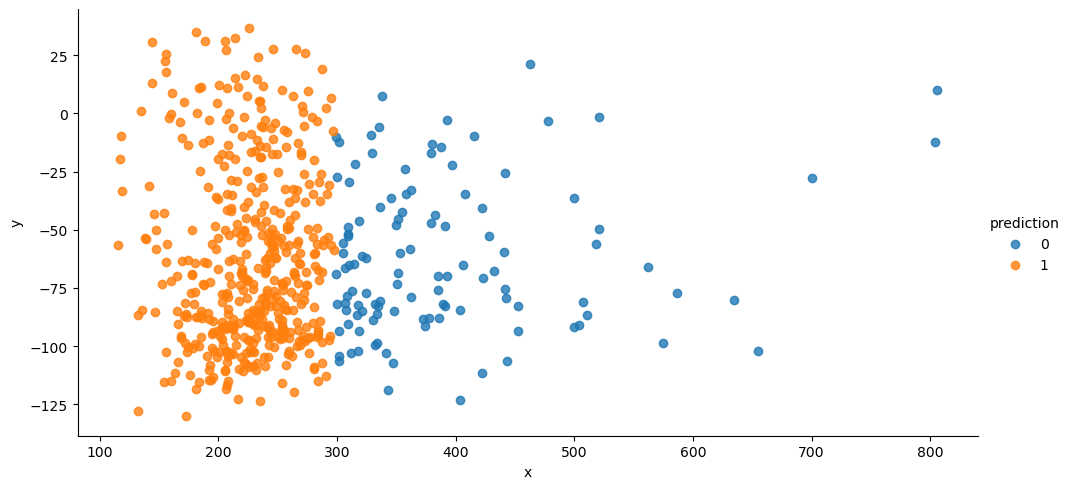

In [63]:
seaborn.lmplot(data = df, x = "x", y = "y", hue = "prediction", 
               fit_reg = False, height = 5, aspect = 2)